In [224]:

import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype
from scipy.stats import norm

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=12,
    titlepad=9,
)

# Mute warnings
warnings.filterwarnings('ignore')


## Data Preprocessing ##

Before we can do any feature engineering, we need to *preprocess* the data to get it in a form suitable for analysis. The data we used in the course was a bit simpler than the competition data. For the *Ames* competition dataset, we'll need to:
- **Load** the data from CSV files
- **Clean** the data to fix any errors or inconsistencies
- **Encode** the statistical data type (numeric, categorical)
- **Impute** any missing values

We'll wrap all these steps up in a function, which will make easy for you to get a fresh dataframe whenever you need. After reading the CSV file, we'll apply three preprocessing steps, `clean`, `encode`, and `impute`, and then create the data splits: one (`df_train`) for training the model, and one (`df_test`) for making the predictions that you'll submit to the competition for scoring on the leaderboard.

In [225]:
def load_data():
    # Read data
    data_dir = Path("../input/house-prices-advanced-regression-techniques/")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df, df_train = clean(df,df_train)
    #df = impute(df)
    #df = impute_2(df)
    df = impute_3(df)
    df = encode(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test


### Clean Data ###

Some of the categorical features in this dataset have what are apparently typos in their categories:

In [226]:
def clean(df, df_train):
    #Computar porcentaje de valores faltantes, remover columnas que sobrepasen el umbral de 15%.
    missing = df_train.isna().sum(axis=0).sort_values(ascending=False)
    percent = df_train.isna().sum(axis=0) / df_train.shape[0]
    pdm = pd.concat([missing,percent], axis=1, keys=["Missing","Percentage"])    
    df = df.drop((pdm[pdm["Percentage"]>0.15]).index,axis=1)
    #Eliminar fila con valor de "Electrical" faltante
    removed_indexes = df[df["Electrical"].isna()].index
    df = df.drop(removed_indexes)
    df_train = df_train.drop(removed_indexes)
    #df = df.reset_index()
    
    #Función original
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df, df_train


In [227]:

# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", 
                "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", 
                "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        if name in df.columns:
            df[name] = df[name].astype("category")
            # Add a None category for missing values
            if "None" not in df[name].cat.categories:
                df[name] = df[name].cat.add_categories("None")
    # Ordinal categories
    for name, levels in ordered_levels.items():
        if name in df.columns:
            df[name] = df[name].astype(CategoricalDtype(levels,
                                                        ordered=True))
    return df


### Handle Missing Values ###

Handling missing values now will make the feature engineering go more smoothly. We'll impute `0` for missing numeric values and `"None"` for missing categorical values. You might like to experiment with other imputation strategies. In particular, you could try creating "missing value" indicators: `1` whenever a value was imputed and `0` otherwise.

In [228]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

def impute_2(df):
    df["Imputed"] = 0
    for name in df.select_dtypes("number"):
        df.loc[df[name].isna(),name] = 0
        df.loc[df[name].isna(),"Imputed"] = 1
    for name in df.select_dtypes("category"):
        df.loc[df[name].isna(),name] = None
        df.loc[df[name].isna(),"Imputed"] = 1
    return df

def impute_3(df):
    df["Imputed"] = 0
    for name in df.select_dtypes("number"):
        df.loc[df[name].isna(),name] = 0
        df.loc[df[name].isna(),"Imputed"] = 1
    for name in df.select_dtypes("category"):
        df = df.drop(df.loc[df[name].isna()])
    return df

## Load Data ##

And now we can call the data loader and get the processed data splits:

In [229]:
df_train, df_test = load_data()

Uncomment and run this cell if you'd like to see what they contain. Notice that `df_test` is
missing values for `SalePrice`. (`NA`s were willed with 0's in the imputation step.)

In [230]:
# Peek at the values
display(df_train)
display(df_test)

# Display information about dtypes and missing values
display(df_train.info())
display(df_test.info())

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,Threeseasonporch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Imputed
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,2,2008,WD,Normal,208500.0,0
2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,5,2007,WD,Normal,181500.0,0
3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,9,2008,WD,Normal,223500.0,0
4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,0,0,0,0,2,2006,WD,Abnorml,140000.0,0
5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,12,2008,WD,Normal,250000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,...,0,0,0,0,8,2007,WD,Normal,175000.0,0
1457,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,...,0,0,0,0,2,2010,WD,Normal,210000.0,0
1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,...,0,0,0,2500,5,2010,WD,Normal,266500.0,0


,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,Threeseasonporch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Imputed
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,120,0,0,6,2010,WD,Normal,0.0,0
1462,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,0,0,0,12500,6,2010,WD,Normal,0.0,0
1463,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,0,0,0,0,3,2010,WD,Normal,0.0,0
1464,60,RL,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,0,0,0,0,6,2010,WD,Normal,0.0,0
1465,120,RL,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,...,0,144,0,0,1,2010,WD,Normal,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,...,0,0,0,0,6,2006,WD,Normal,0.0,0
2916,160,RM,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,...,0,0,0,0,4,2006,WD,Abnorml,0.0,0
2917,20,RL,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,...,0,0,0,0,9,2006,WD,Abnorml,0.0,0


<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 1 to 1460
Data columns (total 74 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1459 non-null   category
 1   MSZoning          1459 non-null   category
 2   LotArea           1459 non-null   int64   
 3   Street            1459 non-null   category
 4   LotShape          1459 non-null   category
 5   LandContour       1459 non-null   category
 6   Utilities         1459 non-null   category
 7   LotConfig         1459 non-null   category
 8   LandSlope         1459 non-null   category
 9   Neighborhood      1459 non-null   category
 10  Condition1        1459 non-null   category
 11  Condition2        1459 non-null   category
 12  BldgType          1459 non-null   category
 13  HouseStyle        1459 non-null   category
 14  OverallQual       1441 non-null   category
 15  OverallCond       1459 non-null   category
 16  YearBuilt         1459 non-nu

None

<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 1461 to 2919
Data columns (total 74 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1459 non-null   category
 1   MSZoning          1455 non-null   category
 2   LotArea           1459 non-null   int64   
 3   Street            1459 non-null   category
 4   LotShape          1459 non-null   category
 5   LandContour       1459 non-null   category
 6   Utilities         1457 non-null   category
 7   LotConfig         1459 non-null   category
 8   LandSlope         1459 non-null   category
 9   Neighborhood      1459 non-null   category
 10  Condition1        1459 non-null   category
 11  Condition2        1459 non-null   category
 12  BldgType          1459 non-null   category
 13  HouseStyle        1459 non-null   category
 14  OverallQual       1446 non-null   category
 15  OverallCond       1459 non-null   category
 16  YearBuilt         1459 non

None

## Establish Baseline ##

Finally, let's establish a baseline score to judge our feature engineering against.

Here is the function we created in Lesson 1 that will compute the cross-validated RMSLE score for a feature set. We've used XGBoost for our model, but you might want to experiment with other models.


In [231]:

def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


We can reuse this scoring function anytime we want to try out a new feature set. We'll run it now on the processed data with no additional features and get a baseline score:

In [232]:
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14266 RMSLE


This baseline score helps us to know whether some set of features we've assembled has actually led to any improvement or not.

# Step 2 - Feature Utility Scores #

In Lesson 2 we saw how to use mutual information to compute a *utility score* for a feature, giving you an indication of how much potential the feature has. This hidden cell defines the two utility functions we used, `make_mi_scores` and `plot_mi_scores`: 

In [233]:

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

Let's look at our feature scores again:

In [234]:
df_train.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,Threeseasonporch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Imputed
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,2,2008,WD,Normal,208500.0,0
2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,5,2007,WD,Normal,181500.0,0
3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,9,2008,WD,Normal,223500.0,0
4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,0,0,0,0,2,2006,WD,Abnorml,140000.0,0
5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,12,2008,WD,Normal,250000.0,0


In [235]:
X = df_train.copy()
y = X.pop("SalePrice")

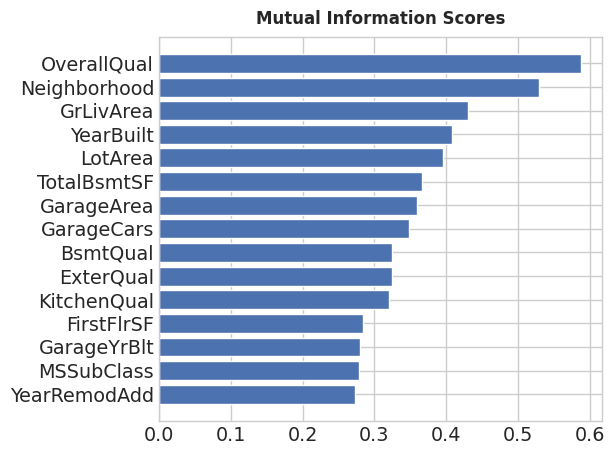

In [236]:
mi_scores = make_mi_scores(X, y)
plot_mi_scores(mi_scores[:15])

In [237]:
print(mi_scores.axes[0][:10])

Index(['OverallQual', 'Neighborhood', 'GrLivArea', 'YearBuilt', 'LotArea',
       'TotalBsmtSF', 'GarageArea', 'GarageCars', 'BsmtQual', 'ExterQual'],
      dtype='object')


# Análisis Gráfico

Esta sección está basada en este [post](https://www.kaggle.com/code/arcielbaez/trying-some-data-exploration).

Esta grilla permite vislumbrar los tipos de relaciones que existen entre las variables: lineales, cuadráticas, etc. 
Este primer caso incluye algunas variables que resultan interesantes gracias a conocimiento sobre el dominio del problema. Se observa que el precio de venta tiene una relación lineal con el tamaño del área de la vivienda y los pies cuadrados cubiertos por el sótano. También existe una relación interesante respecto al año en que fue construida la vivienda y el precio de venta. La cantidad de autos en el garage acusa una posible correlación importante.

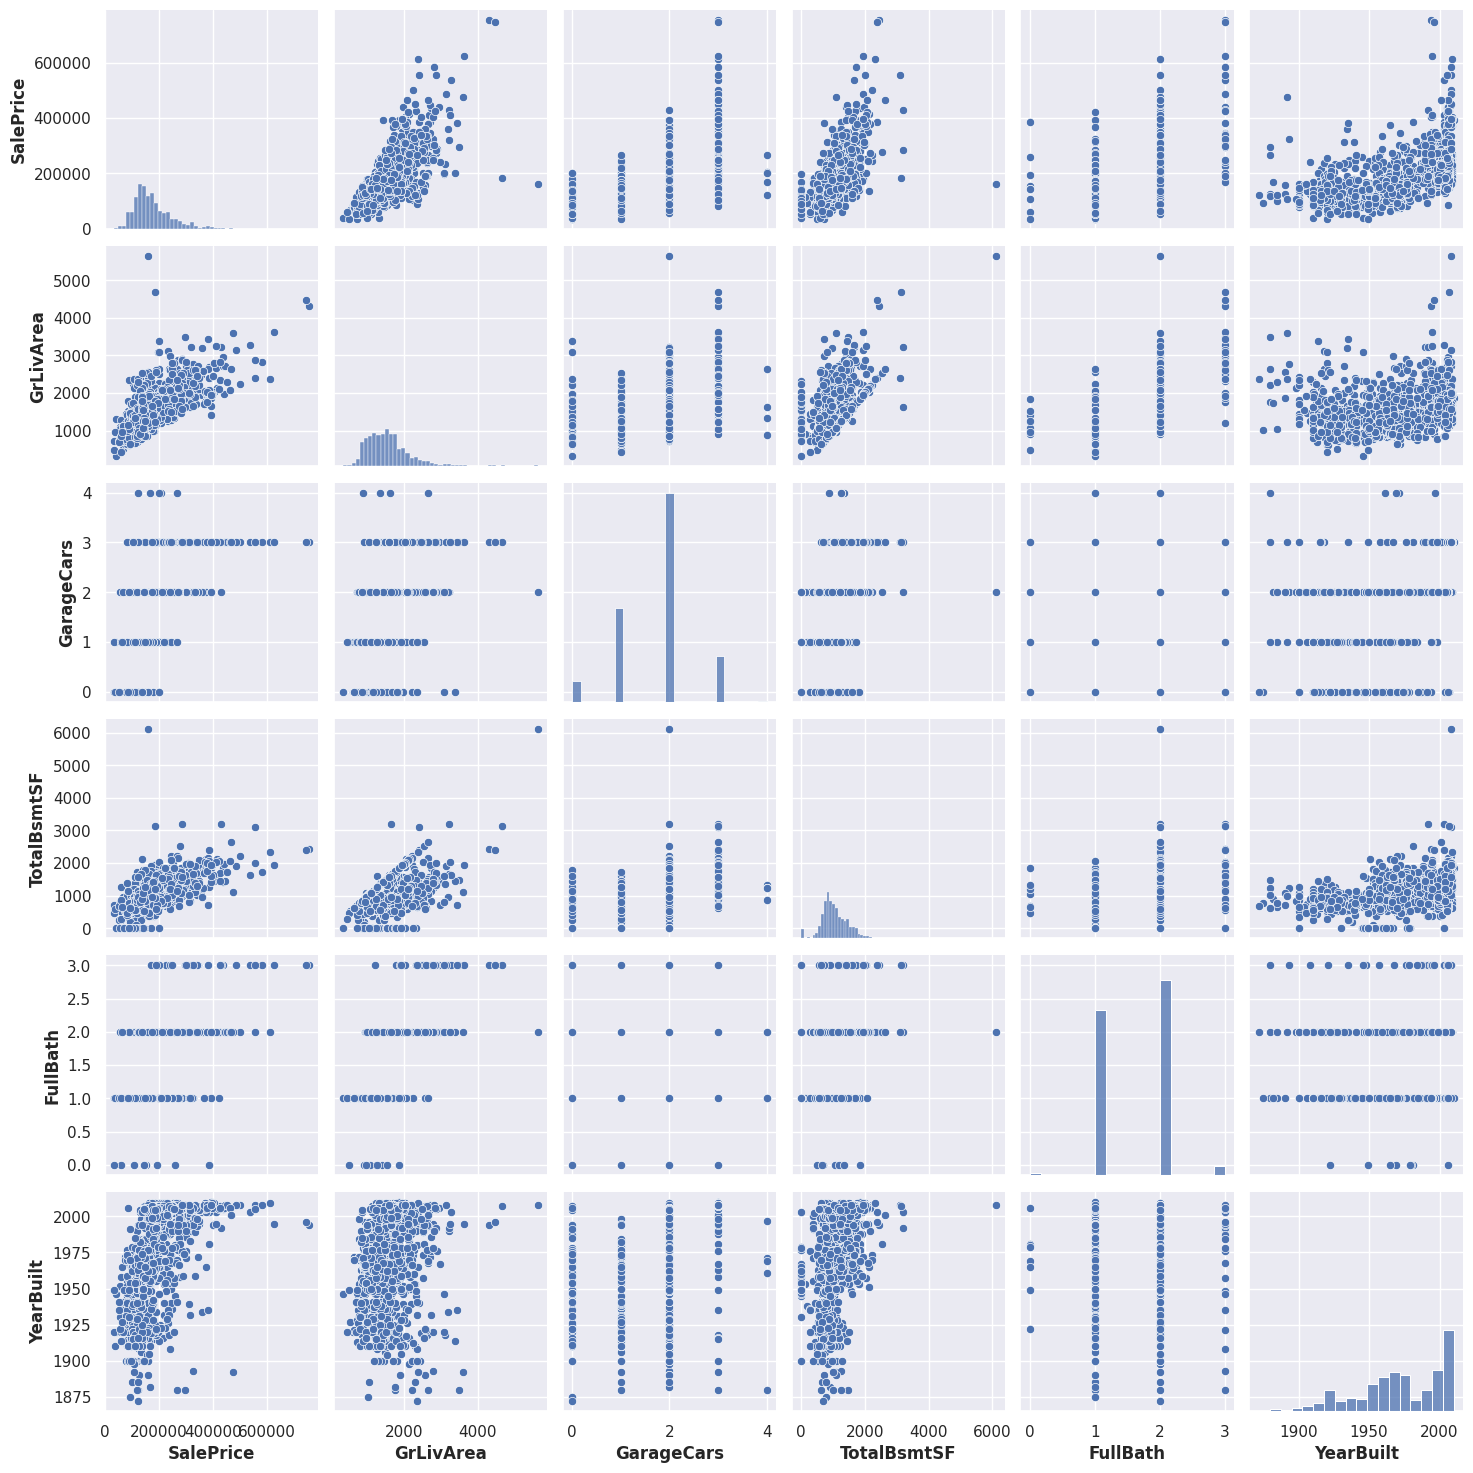

In [238]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

Esta segunda grilla incluye a las variables con mayor valor de información mutua respecto al precio de venta de la vivienda. La información mutua reporta qué tanto puede llegarse a saber respecto al valor objetivo a partir de alguna otra variable individual. Es un buen lugar donde comenzar el análisis cuando se trabaja con un dataset nuevo. En este caso se repiten múltiples variables del caso anterior.

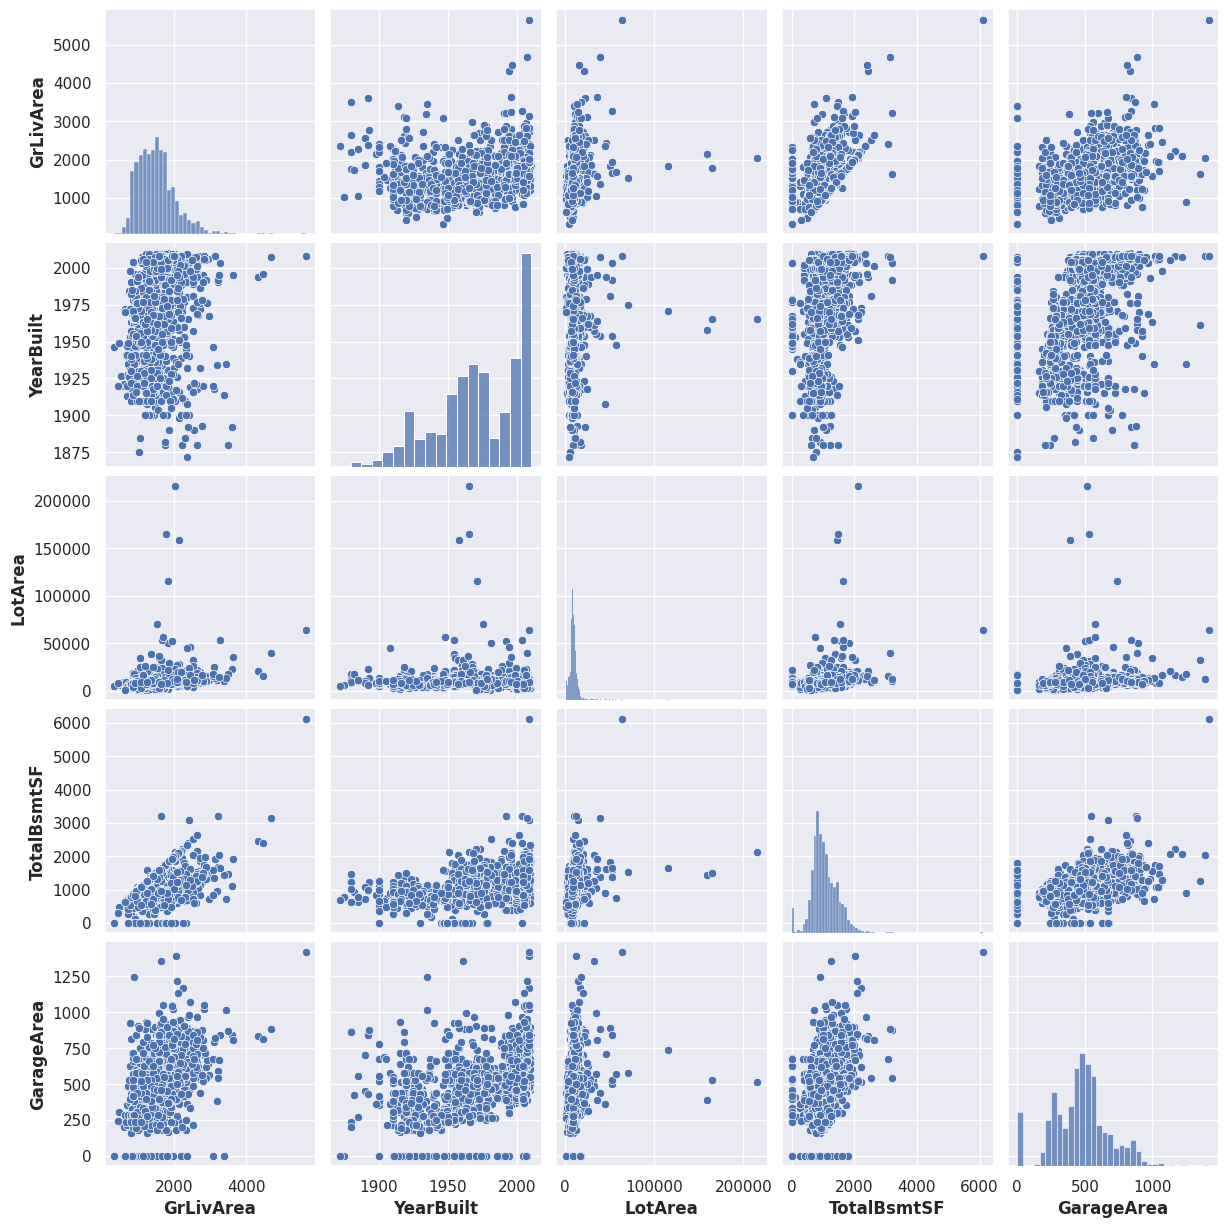

In [239]:
sns.set()
sns.pairplot(df_train[mi_scores.axes[0][:7]], size = 2.5)
plt.show();

## Análisis de variables respecto al precio de venta

Para obtener mejor perspectiva acerca de cómo ciertas variables estan relacionadas al precio de venta, se realizan los gráficos a continuación.

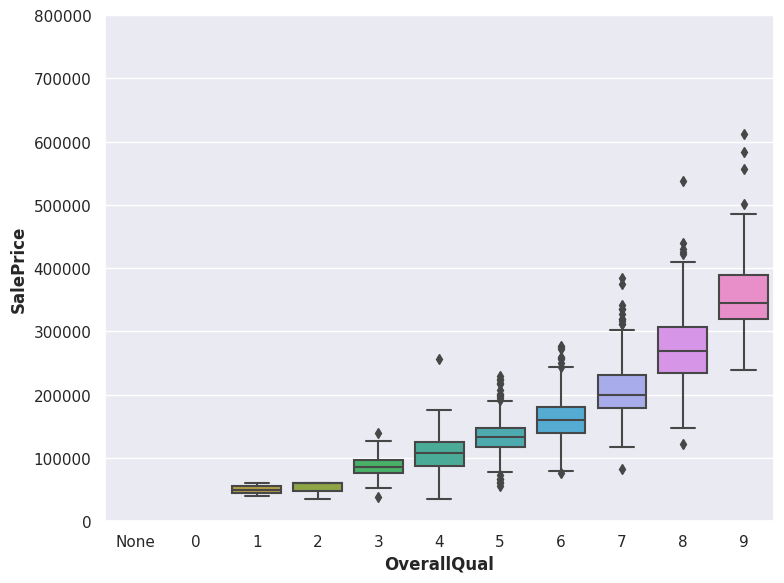

In [240]:
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

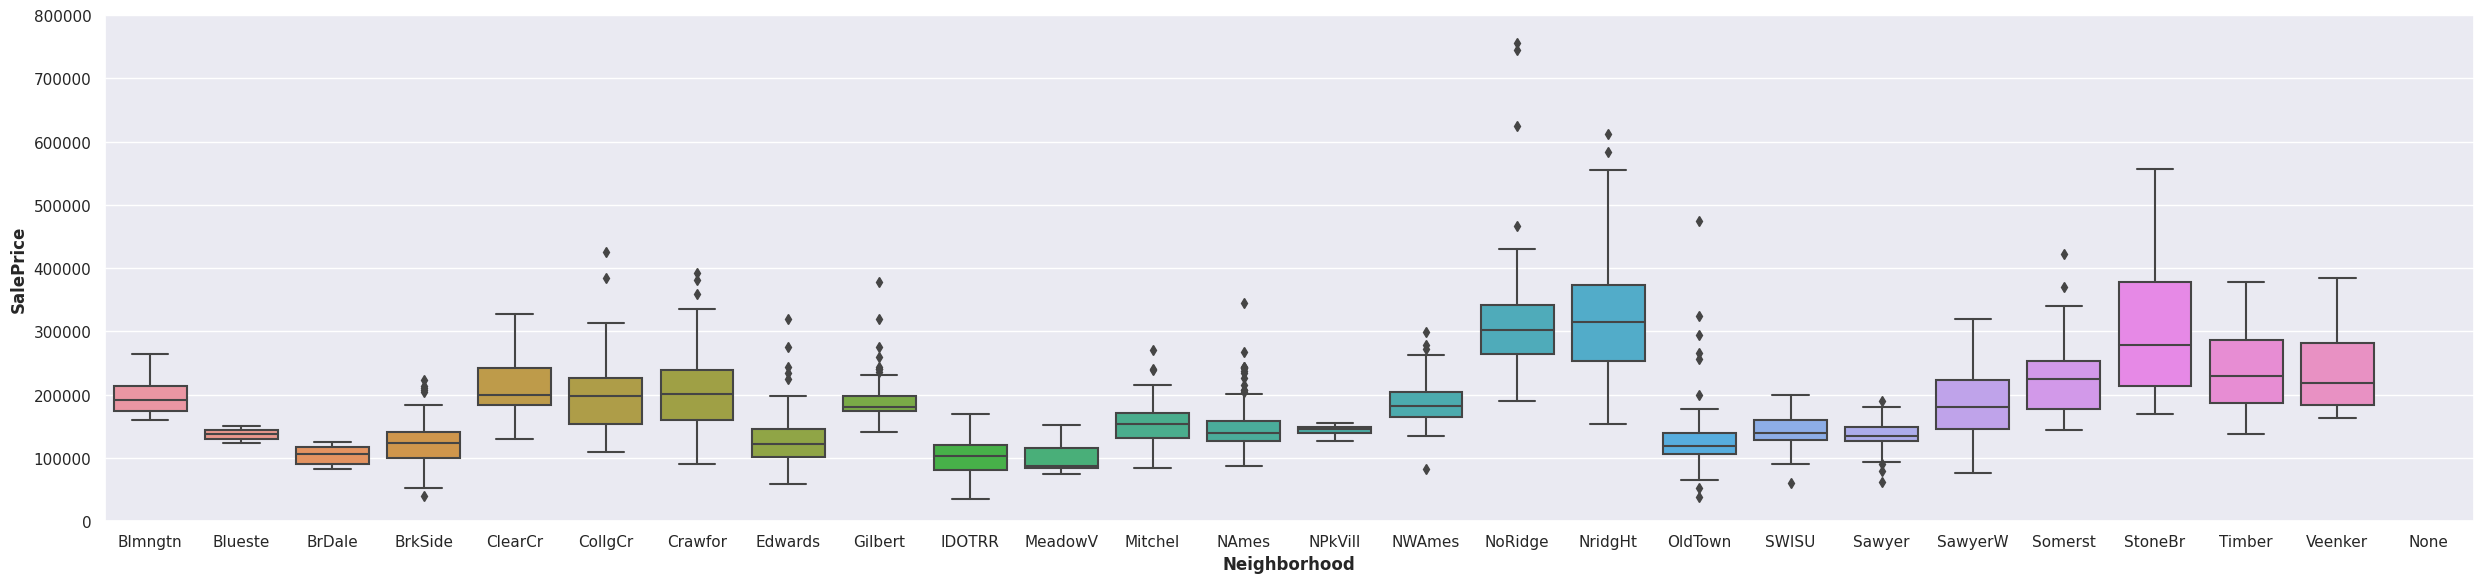

In [241]:
var = 'Neighborhood'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(25, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

Ambos parámetros anteriores exhiben una marcada estratificación entre los precios de venta.
Por otra parte, en el gráfico de precio vs área del piso de la vivienda (el mismo de la grilla anterior), se observan outliers que sería apropiado soslayar al entrenar el modelo.

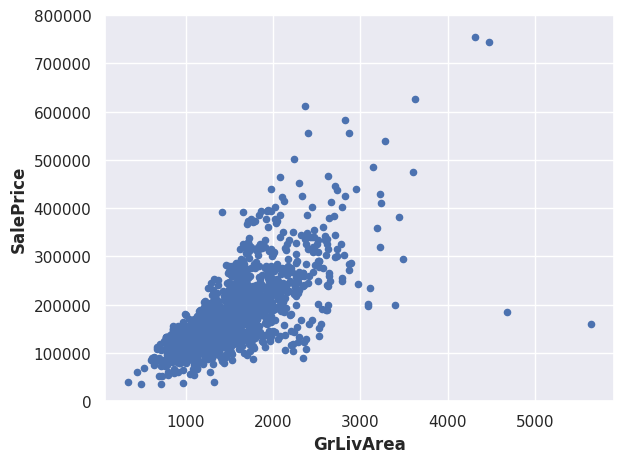

In [242]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

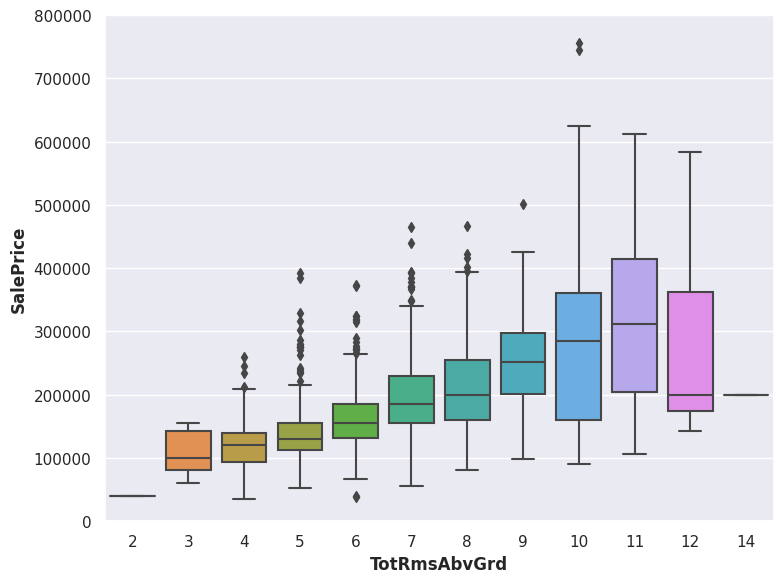

In [243]:
var = 'TotRmsAbvGrd'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

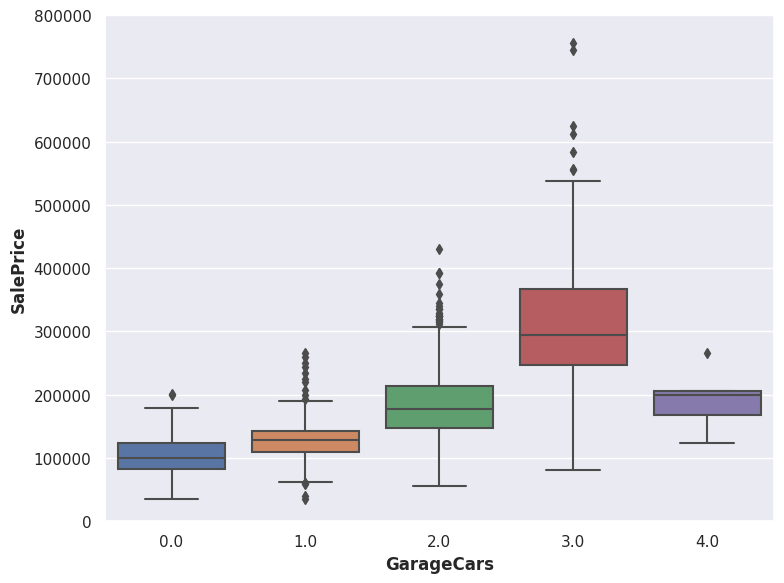

In [244]:
var = 'GarageCars'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

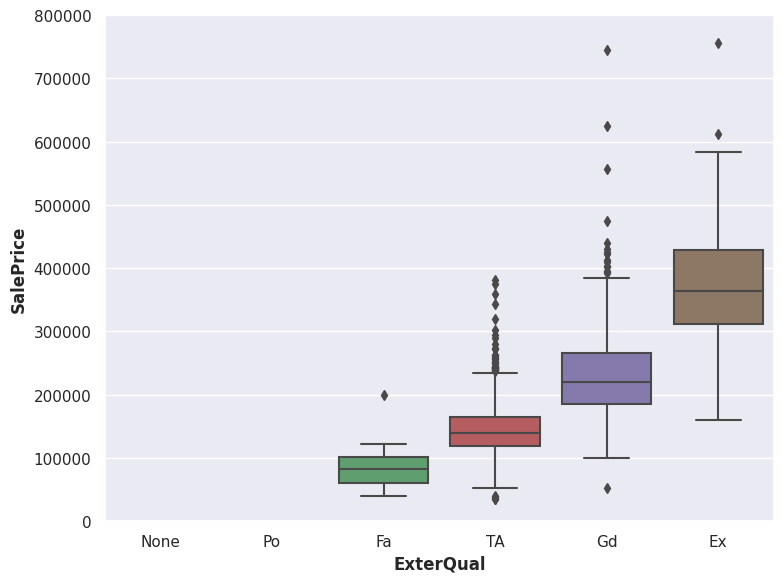

In [245]:
var = 'ExterQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

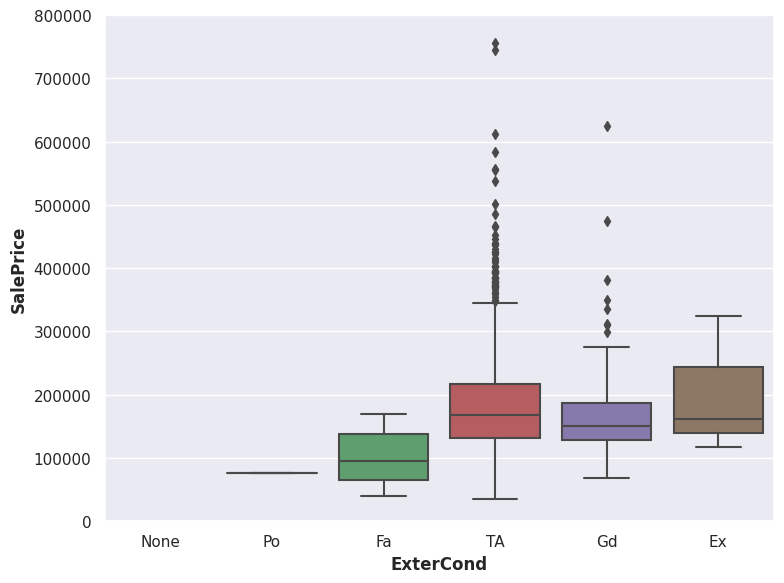

In [246]:
var = 'ExterCond'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

## Características de sótano

La cantidad de pies cuadrados del sótano presenta una relación casi lineal respecto al precio de venta, como se observó anteriormente. Los gráficos de dispersión a continuación también contienen a las muestras agrupadas de acuerdo a su tipo de terminado.

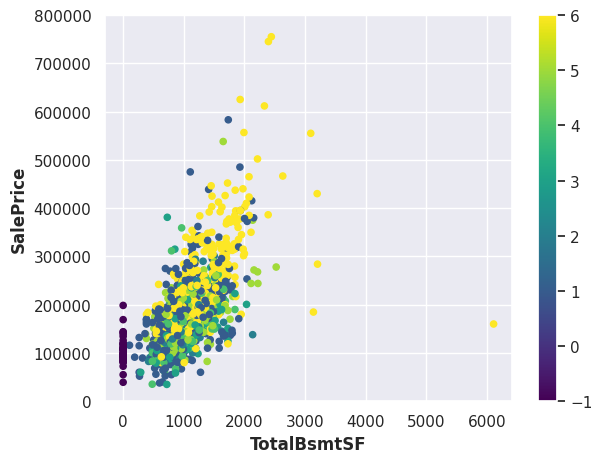

In [247]:
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000), c = df_train["BsmtFinType1"].cat.codes, colormap='viridis');

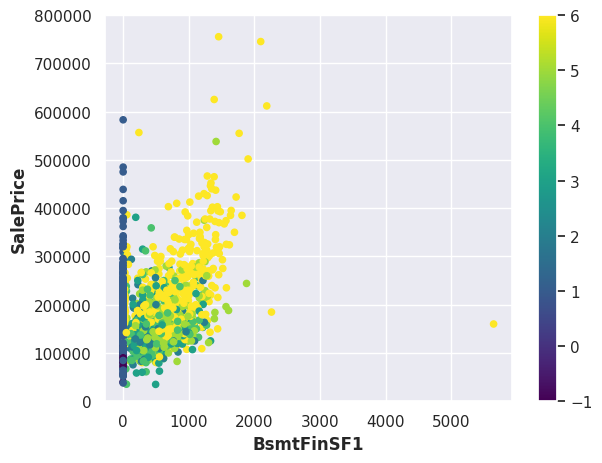

In [248]:
var = 'BsmtFinSF1'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000), c = df_train["BsmtFinType1"].cat.codes, colormap='viridis');

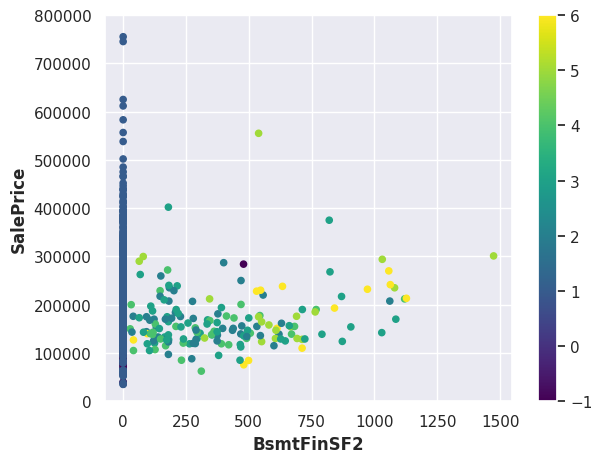

In [249]:
var = 'BsmtFinSF2'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000), c = df_train["BsmtFinType2"].cat.codes, colormap='viridis');

Finalmente, se explora la relación de los tipos de terminado, la condición y calidad del sótano respecto al precio de venta de la vivienda.

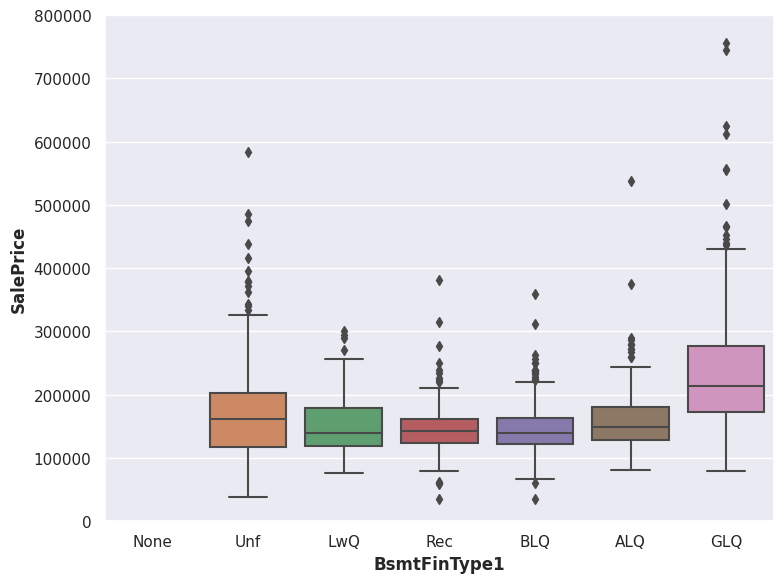

In [250]:
var = 'BsmtFinType1'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

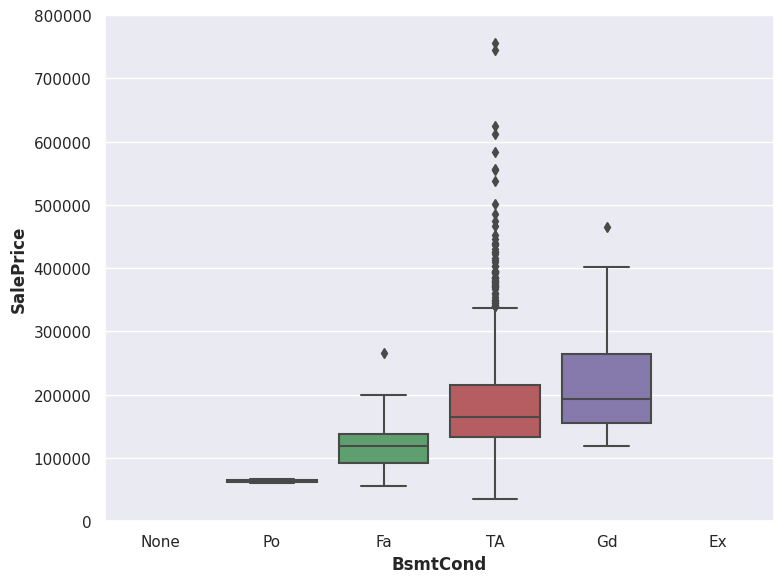

In [251]:
var = 'BsmtCond'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

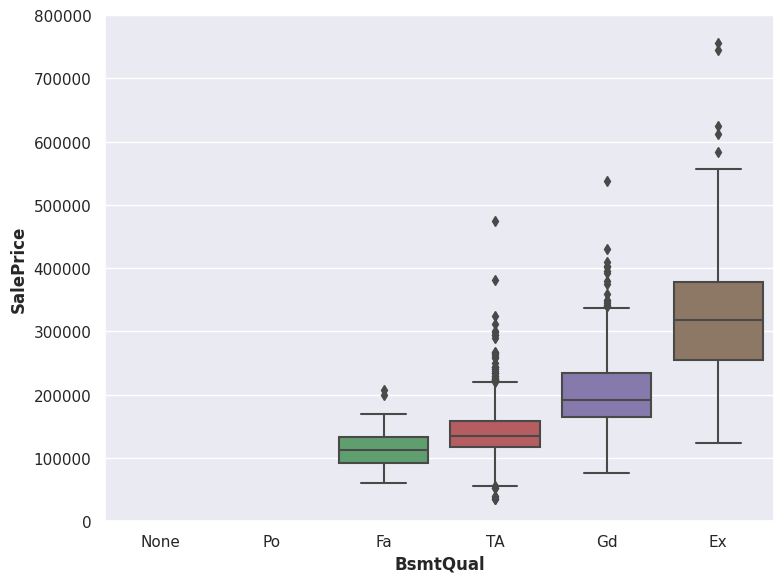

In [252]:
var = 'BsmtQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

## Suposiciones estadísticas para técnicas multivariable

Esta sección proviene de este [post](https://www.kaggle.com/code/arcielbaez/trying-some-data-exploration).

Según [Hair et al. (2013)](https://www.amazon.com/Multivariate-Data-Analysis-Joseph-Hair/dp/9332536503/ref=as_sl_pc_tf_til?tag=pmarcelino-20&linkCode=w00&linkId=5e9109fa2213fef911dae80731a07a17&creativeASIN=9332536503), 4 suposiciones deben ser comprobadas antes de aplicar técnicas multivariables: normalidad, homocedasticidad, linearidad y ausencia de errores correlacionados. El precio de venta ya exhibe una relación lineal respecto a ciertas variables de interés, como fue observado en los gráficos anteriores.

El siguiente ejercicio busca asegurar la normalidad, es decir, comportamiento de acuerdo a una distribución normal, de ciertas variables individuales. Si bien normalidad univariable no asegura normalidad multivariable, ayuda de igual forma, pues elimina la posibilidad de otros problemas como heterocesdasticidad. Para hacerlo se prestará atención al histograma de la variable, y en particular, a la curtosis y asimetría de la distribución. Además, los datos deberían seguir de cerca a la diagonal del gráfico de probabilidad normal.


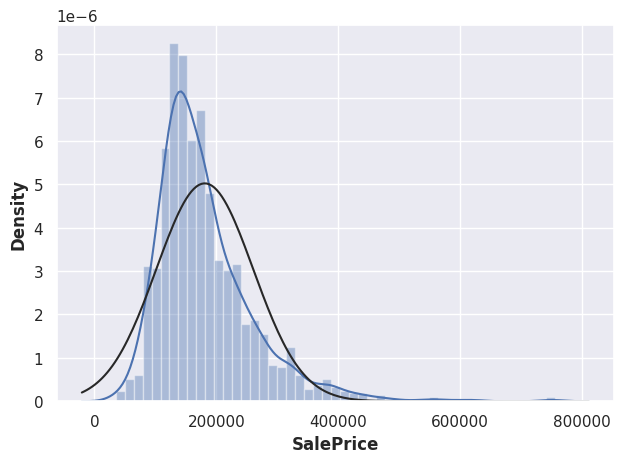

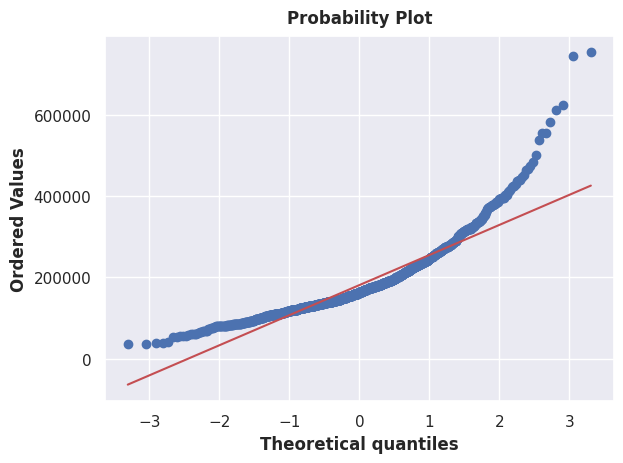

In [253]:
from scipy import stats
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

Se observa que el histograma de precios posee asimetría positiva y además no sigue la línea diagonal, sin embargo, una transformación logarítmica puede resolver el problema.

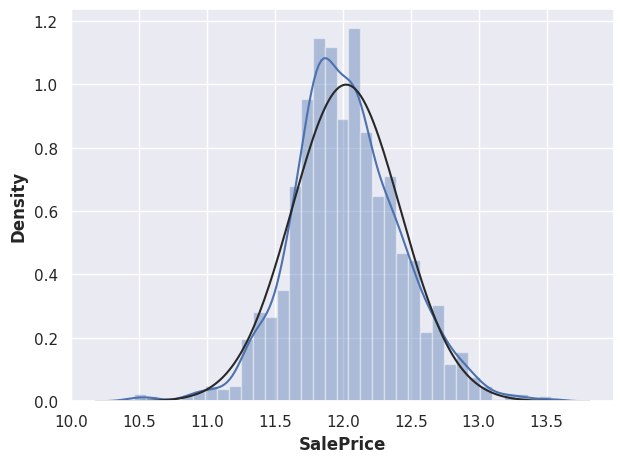

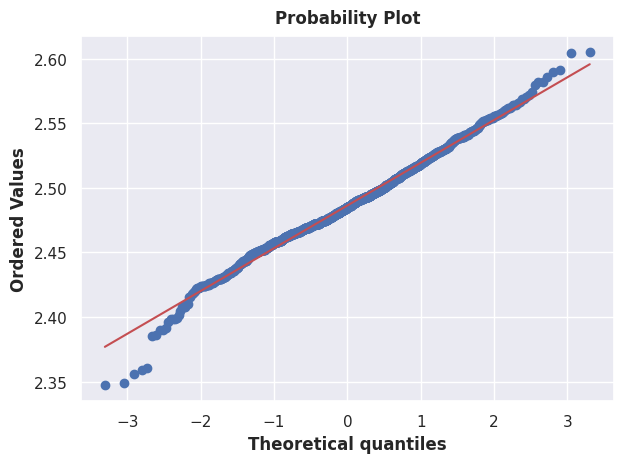

In [254]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(np.log(df_train['SalePrice']), plot=plt)

Algo similar ocurre con la variable de área habitable.

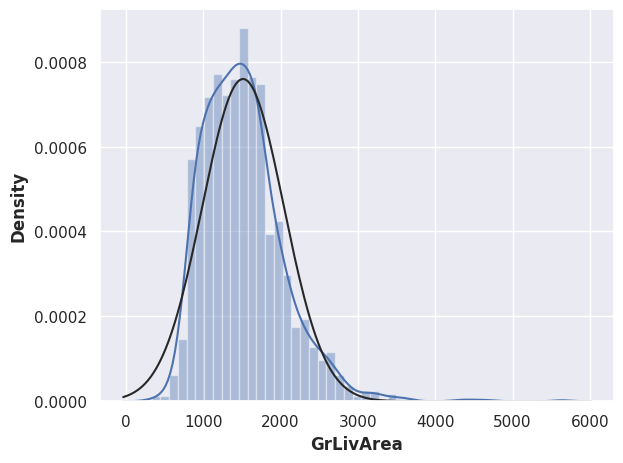

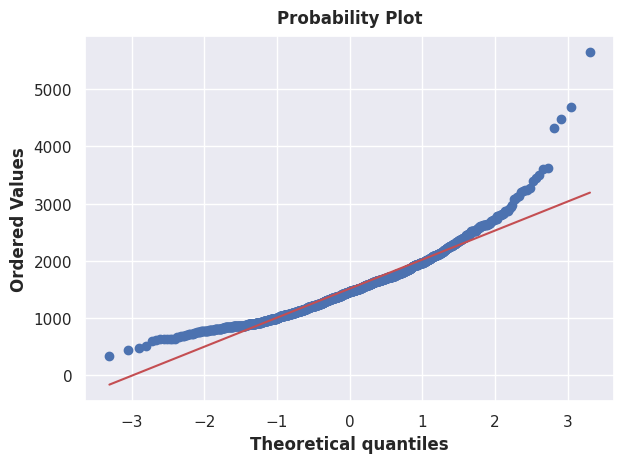

In [255]:
from scipy import stats
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

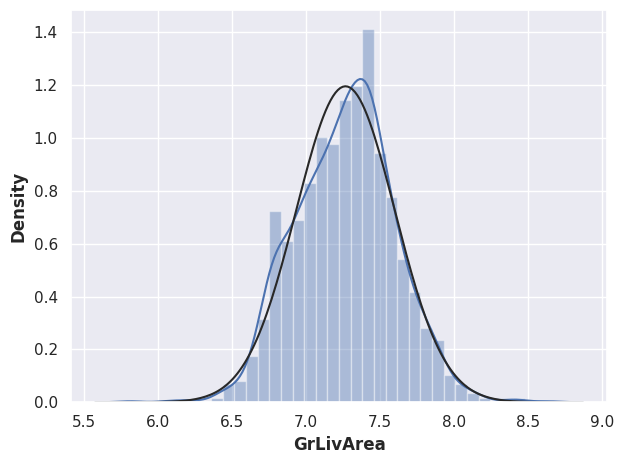

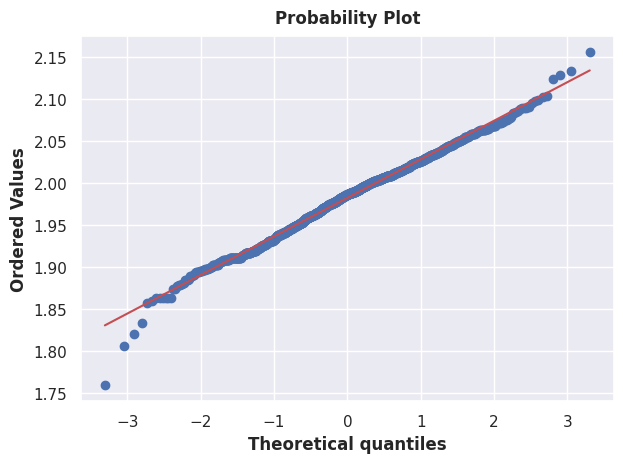

In [256]:
df_train["GrLivArea"] = np.log(df_train['GrLivArea'])
sns.distplot(df_train["GrLivArea"], fit=norm);
fig = plt.figure()
res = stats.probplot(np.log(df_train['GrLivArea']), plot=plt)

Para el caso del tamaño del sótano, ocurre algo distinto.

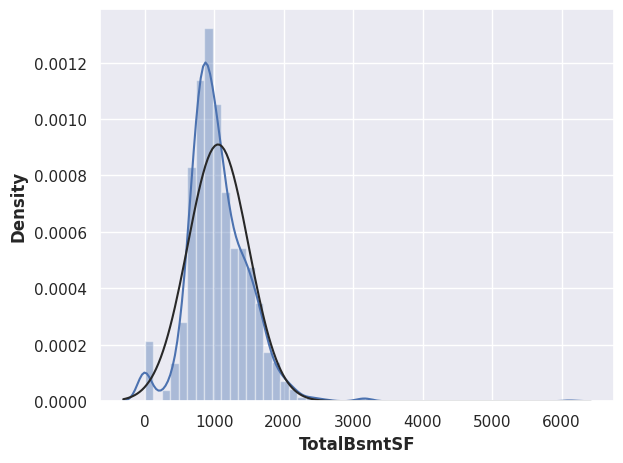

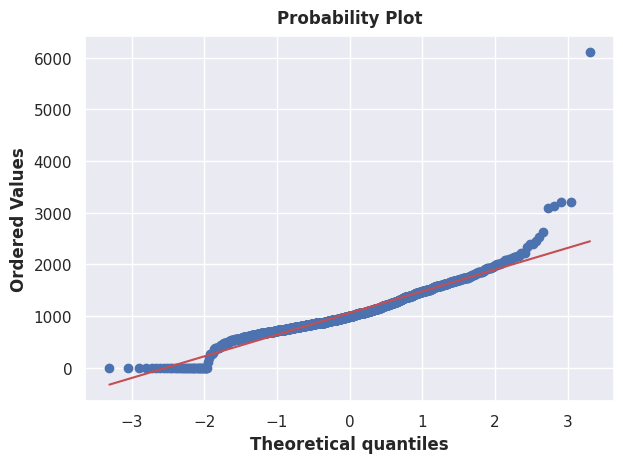

In [257]:
sns.distplot(df_train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot=plt)

La distribución posee asimetría, pero también ocurre que existen ciertas viviendas sin sótano, lo que impide ocupar una transformación logarítmica. Una manera de abordar esta situación es crear una variable binaria que separe a los casos sin sótano, y aplicar la transformación a los casos adecuados.

In [258]:
df_train["HasBsmt"] =  pd.Series(df_train.shape[0], index=df_train.index)
df_train["HasBsmt"] = 0
df_train.loc[df_train["TotalBsmtSF"] > 0, "HasBsmt" ] = 1

df_train.loc[df_train["HasBsmt"] == 1, "TotalBsmtSF"] = np.log(df_train["TotalBsmtSF"])

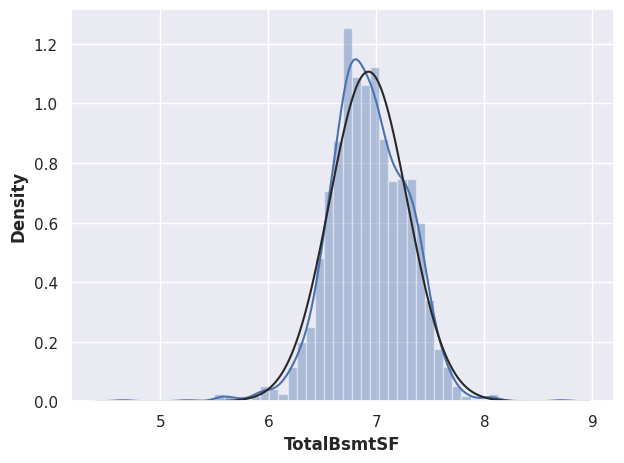

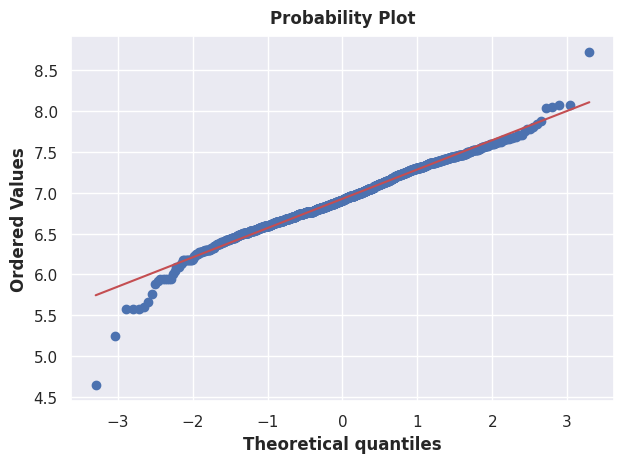

In [259]:
sns.distplot(df_train.loc[df_train['HasBsmt']==1,"TotalBsmtSF"], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train.loc[df_train['HasBsmt']==1,"TotalBsmtSF"], plot=plt)

Los siguientes gráficos ayudan a observar la homocedasticidad: la uniformidad de la dispersión de los datos se refleja en la forma de la nube de los mismos. Una forma de diamante (más ancha en el centro) o de cono (más ancha en uno de los extremos) es evidencia de divergencia en la dispersiones. Lo anterior ocurre en los gráficos de la grilla elaborados anteriormente. El gráfico a continuación muestra como dicho efecto es neutralizado al asegurar la normalidad de las variables.

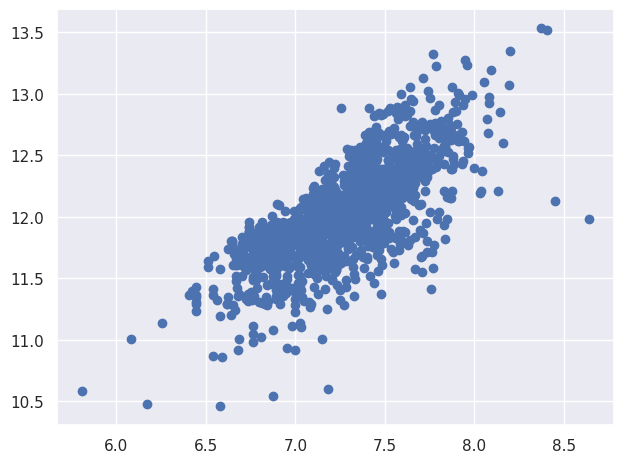

In [260]:
plt.scatter(df_train['GrLivArea'], df_train['SalePrice']);

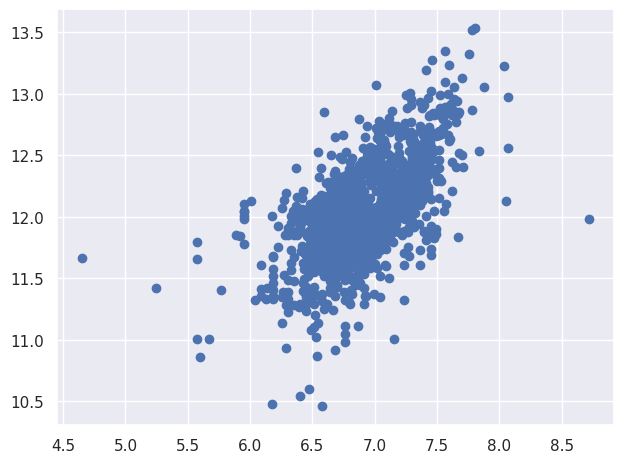

In [261]:
#scatter plot
plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], df_train[df_train['TotalBsmtSF']>0]['SalePrice']);

In [262]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]


In [263]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X


## Creación de características ##


In [264]:

def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    
    #Eliminar outlier del cálculo
    mean = df.loc[df["BsmtFinSF1"]<5000 , "BsmtFinSF1"].mean(axis=0)
    std = df.loc[df["BsmtFinSF1"]<5000, "BsmtFinSF1"].std(axis=0)
    
    #Características relativas al  sótano
    X["BsmtSFFinish_1"] =  (df.BsmtFinSF1 - mean) / std
    X["BsmtSFFinish_1"] = X["BsmtSFFinish_1"] * df.BsmtFinType1.cat.codes
    
    #X["BsmtSFFinish_1"] =  (df.BsmtFinSF1 - df.BsmtFinSF1.mean()) / df.BsmtFinSF1.std()
    #X["BsmtSFFinish_1"] = X["BsmtSFFinish_1"] * df.BsmtFinType1.cat.codes
    
    X["BsmtSFFinish_2"] =  (df.BsmtFinSF2 - df.BsmtFinSF2.mean(axis=0)) / df.BsmtFinSF2.std(axis=0)
    X["BsmtSFFinish_2"] = X["BsmtSFFinish_2"] * df.BsmtFinType2.cat.codes
    
    #Líneas comentadas no mejoraron el desempeño
    # X["BsmtRatio"] = df.TotalBsmtSF / (df.BsmtUnfSF+1)
    
    # Feature from original notebook
    # X["TotalOutsideSF"] = \
    #     df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + \
    #     df.Threeseasonporch + df.ScreenPorch
    return X


def interactions(df):
    # Multiplica tipo de estructura por el espacio habitable
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X


def counts(df):
    #Campo que agrega características que pueden resultar útiles al ser contabilizadas en conjunto
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X


def break_down(df):
    # Separa y captura palabra relevante en los strings del campo MSClass 
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X


def group_transforms(df):
    # Técnicas de agrupación. Útil para ciertos casos observados donde pertenencia a cierto grupo es relevante, como el caso del vecindario observado en los boxplots.
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X

def overall_combined(df):
    # Función que combina características de un mismo tipo: estado del exterior de la vivienda, estado del sótano, estado del garage, etc.
    X = pd.DataFrame()
    df_aux = df.dropna(subset=['OverallCond','OverallQual','ExterQual','ExterCond','ExterQual','ExterCond','GarageQual','GarageCond'])
    X["OverallCombined"] = df_aux["OverallCond"].cat.codes.astype("float") * df_aux["OverallQual"].cat.codes.astype("float")
    
   # df_aux = df.dropna(subset=['ExterQual','ExterCond'])
    X["ExterCombined"] = df_aux["ExterQual"].cat.codes.astype("float") * df_aux["ExterCond"].cat.codes.astype("float")
    
    #df_aux = df.dropna(subset=['ExterQual','ExterCond'])
    X["BsmtCombined"] = df_aux["BsmtQual"].cat.codes.astype("float") * df_aux["BsmtCond"].cat.codes.astype("float")
    
    #df_aux = df.dropna(subset=['GarageQual','GarageCond'])
    X["GarageCombined"] = df_aux["GarageQual"].cat.codes.astype("float") * df_aux["GarageCond"].cat.codes.astype("float")
    
    return X
    
def app_log(df):
    # Transformación logarítmica a ciertos campos
    df["GrLivArea"].apply(np.log)
    #df["LotFrontage"].apply(np.log)
    df["LotArea"].apply(np.log)
    return df 

def square(df):
    #Eleva al cuadrado medidas de pies cuando corresponda
    X = pd.DataFrame()
    columnas_sf = [col for col in df.columns if "SF" in col]
    for col in columnas_sf:
        X[f"{col}_lineal"] = df[col].apply(np.sqrt)
    return X

def basement(df):
    #Indicador binario para existencia de sótano
    df["HasBsmt"] =  pd.Series(df.shape[0], index=df.index)
    df["HasBsmt"] = 0
    df.loc[df["TotalBsmtSF"] > 0, "HasBsmt" ] = 1

    df.loc[df["HasBsmt"] == 1, "TotalBsmtSF"] = np.log(df["TotalBsmtSF"])
    return df
    

## k-Means Clustering ##


In [265]:

cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd


## Principal Component Analysis ##



In [266]:

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


In [267]:

def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

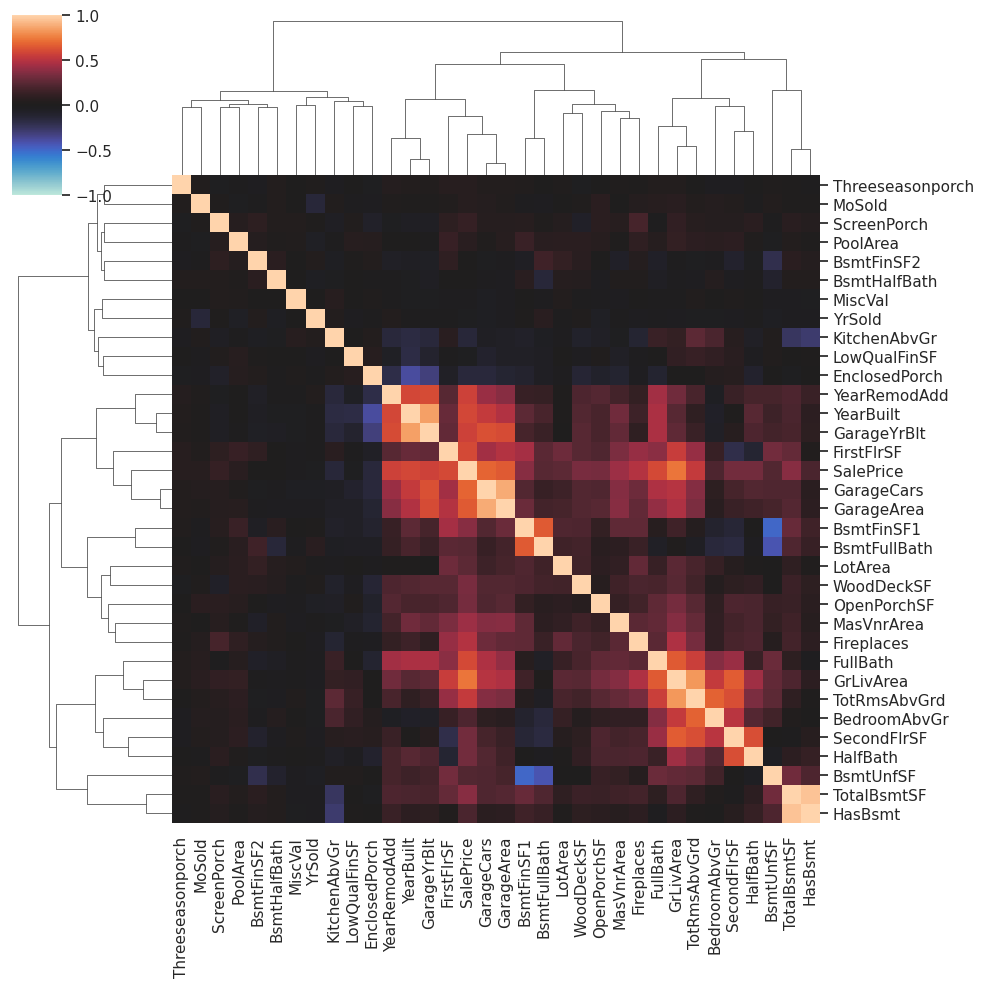

In [268]:

def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.iloc[:,~df.columns.isin(["Imputed"])].corr(method, numeric_only=True),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None)

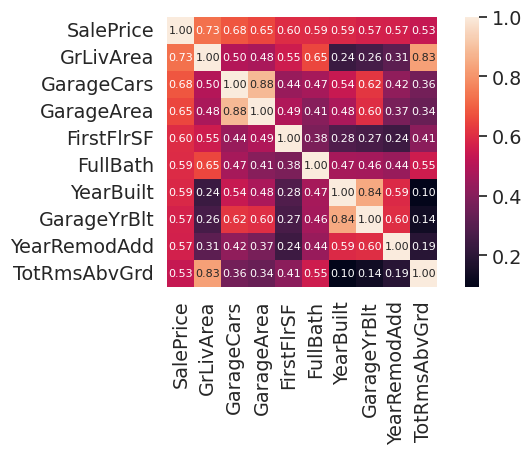

In [269]:
corrmat = df_train.corr(numeric_only=True)
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Las matrices de correlación permiten identificar variables que pueden ser omitidas de acuerdo a su nivel de correlación. Por ejemplo, "GarageCars" y "GarageArea" están altamente correlacionados, lo cual es razonable. Por lo tanto, dado que "GarageCars" tiene un mayor índice de correlación con el precio de venta, este será la variable conservada para el entrenamiento. Además permiten evaluar buenos candidatos para ser usados como variables predictoras.



### PCA Application - Indicate Outliers ###


In [270]:
def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial")
    return X_new


## Target encoding ##

In [271]:

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded



## Create Final Feature Set ##

In [272]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Lesson 2 - Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Lesson 3 - Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    # X = X.join(break_down(X))
    X = X.join(group_transforms(X))
    #X = X.join(overall_combined(X))
    #X = basement(X)

    # Lesson 4 - Clustering
    # X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    # X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

    # Lesson 5 - PCA
    X = X.join(pca_inspired(X))
    # X = X.join(pca_components(X, pca_features))
    # X = X.join(indicate_outliers(X))
    X = app_log(X)
   # X = X.join(square(X))
    X = label_encode(X)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Lesson 6 - Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X


df_train, df_test = load_data()
X_train,X_test = create_features(df_train,df_test)
y_train = np.log(df_train.loc[:, "SalePrice"])


score_dataset(X_train, y_train)

0.011652728245697953

In [274]:
assert not np.any(np.isnan(X_train))
assert not np.any(np.isnan(X_test))

Epoch 1/200
103/103 [==============================] - 4s 9ms/step - loss: 10.2840 - val_loss: 198.9261
Epoch 2/200
103/103 [==============================] - 1s 7ms/step - loss: 4.4690 - val_loss: 117.8970
Epoch 3/200
103/103 [==============================] - 1s 7ms/step - loss: 2.3596 - val_loss: 34.4510
Epoch 4/200
103/103 [==============================] - 1s 7ms/step - loss: 1.8797 - val_loss: 5.8534
Epoch 5/200
103/103 [==============================] - 1s 6ms/step - loss: 1.6270 - val_loss: 1.8797
Epoch 6/200
103/103 [==============================] - 1s 6ms/step - loss: 1.4546 - val_loss: 1.2466
Epoch 7/200
103/103 [==============================] - 1s 7ms/step - loss: 1.4263 - val_loss: 0.9716
Epoch 8/200
103/103 [==============================] - 1s 7ms/step - loss: 1.2130 - val_loss: 0.8524
Epoch 9/200
103/103 [==============================] - 1s 7ms/step - loss: 1.2076 - val_loss: 0.5781
Epoch 10/200
103/103 [==============================] - 1s 7ms/step - loss: 1.1191 - 

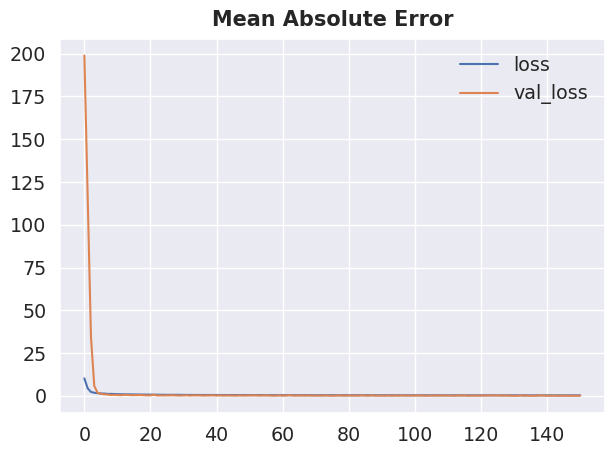

In [114]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3)
optimizer = tf.keras.optimizers.Adam(0.001)

input_shape = [X_train.shape[1]]
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    #layers.Dense(512, activation="relu", input_shape=input_shape),
    layers.Dense(512, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(512, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(1)
])

model.compile(
    optimizer=optimizer,
    loss="mae",
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    x_tr, y_tr,
    validation_data=(x_val, y_val),
    batch_size=10,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Mean Absolute Error")
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));